In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

visits = [1030178, 1030179, 1030180, 1030181, 1030182, 1030183, 1030272, 1030273, 1030274, 1030275, 1030276, 1030277]
filt = 'i2'

bigCat = Table.read('src_catalog_2.fits')

In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

visits = [1030178, 1030179, 1030180, 1030181, 1030182, 1030183, 1030272, 1030273, 1030274, 1030275, 1030276, 1030277]

#Fix the track number for the moment
tract = 8006
filt = 'i2'
butler = dafPersist.Butler("/pbs/throng/lsst/users/boutigny/clusters/MACSJ2243.3-0935/input/rerun/boutigny")

#fluxType = "base_PsfFlux"
fluxType = "slot_ModelFlux"
#fluxType = "base_CircularApertureFlux_6_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]

In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

#butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run2.1i/w_2019_19-v1/rerun/coadd-dr1b-v1")
butler = dafPersist.Butler("/pbs/throng/lsst/users/boutigny/clusters/MACSJ2243.3-0935/input/rerun/boutigny")

In [17]:
filterList = butler.queryMetadata('raw', ["filter"])
filterList

['u', 'g', 'r', 'z', 'i2']

In [21]:
dict(zip(filterList, filterList))

{'u': 'u', 'g': 'g', 'r': 'r', 'z': 'z', 'i2': 'i2'}

In [18]:
import itertools
# dict(zip(*[iter(l)]*2))
d = dict(zip(*[iter(filterList)]))
print(d)

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [7]:
[iter(filterList)] * 2

[<list_iterator at 0x7ff3424289e8>, <list_iterator at 0x7ff3424289e8>]

In [22]:
catList = []
for visit in visits:
    print('Reading visit:', visit)
    for count,data_ref in enumerate(butler.subset('src', visit=visit)):
        if data_ref.datasetExists():
            dataId = data_ref.dataId
        else:
            continue
        dataId['tract'] = tract
        if butler.datasetExists('jointcal_wcs', dataId) == False:
            continue
        if count%10 == 0 :
            print(count, dataId)
        src = butler.get('src', dataId, immediate=True, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
        v = src.asAstropy()
        
        # Get jointcal calibration
        calibJointcal = butler.get('jointcal_photoCalib', dataId)
        srcJointcal = calibJointcal.calibrateCatalog(src).asAstropy()
        # get processCcd calibration
        calibPccd = butler.get("calexp_photoCalib", dataId)
        srcPccd = calibPccd.calibrateCatalog(src).asAstropy()
       
        v['newMag'] = srcJointcal[fluxType + '_mag']
        v['newMagErr'] = srcJointcal[fluxType + '_magErr']
        v['mag'] = srcPccd[fluxType + '_mag']
        v['magErr'] = srcPccd[fluxType + '_magErr']

        # select sources
        cut = np.ones_like(v['id'], dtype=bool)
        for flag in Flags:
            cut &= v[flag]==False
        cut &= (v[fluxType + '_instFlux'] > 0) & (v[fluxType + '_instFlux'] / v[fluxType + '_instFluxErr'] > 5)
        cut &= v['base_ClassificationExtendedness_value'] < 0.5

        cat = v[cut]['id', 'coord_ra', 'coord_dec', fluxType + '_instFlux', 'newMag', 'newMagErr', 'mag', 'magErr']
        # add dataId info
        for k in dataId.keys():
            cat[k] = dataId[k]
            
        # Get WCS info from calexp_wcs and from jointcal_wcs
        oldWcs = butler.get("calexp_wcs", dataId, immediate=True)
        newWcs = butler.get('jointcal_wcs', dataId, immediate=True)
        
        newRa = []
        newDec = []
        pixels = oldWcs.skyToPixel([afwGeom.SpherePoint(ra, dec, afwGeom.radians) for ra, dec in zip(cat['coord_ra'], cat['coord_dec'])])
        newCoord = newWcs.pixelToSky(pixels)                                       
#        for c in cat:
#            pixels = oldWcs.skyToPixel(afwGeom.SpherePoint(c['coord_ra'], c['coord_dec'], afwGeom.radians))
#            newRa.append(float((newWcs.pixelToSky(pixels).getRa())))
#            newDec.append(float((newWcs.pixelToSky(pixels).getDec())))
        cat['newRa'] = [float(cd.getRa()) for cd in newCoord]
        cat['newDec'] = [float(cd.getDec()) for cd in newCoord]
        cat['newRa'].unit = units.rad
        cat['newDec'].unit = units.rad

        # hack to get rid of a warning related to a merging conflict
        cat.meta['NOISE_EXPOSURE_ID'] = 0
         
        # add catalog to the list    
        catList.append(cat)
        
# merge all individual catalogs into a single big one    
bigCat = vstack(catList)


Reading visit: 1030178
0 {'visit': 1030178, 'runId': '08BO01', 'object': 'SCL-2241_P2', 'date': '2008-09-21', 'filter': 'i2', 'ccd': 0, 'extension': 1, 'state': 'p', 'taiObs': '2008-09-21T07:46:45.09', 'expTime': 500.052, 'tract': 8006}
10 {'visit': 1030178, 'runId': '08BO01', 'object': 'SCL-2241_P2', 'date': '2008-09-21', 'filter': 'i2', 'ccd': 10, 'extension': 11, 'state': 'p', 'taiObs': '2008-09-21T07:46:45.09', 'expTime': 500.052, 'tract': 8006}
20 {'visit': 1030178, 'runId': '08BO01', 'object': 'SCL-2241_P2', 'date': '2008-09-21', 'filter': 'i2', 'ccd': 20, 'extension': 21, 'state': 'p', 'taiObs': '2008-09-21T07:46:45.09', 'expTime': 500.052, 'tract': 8006}
30 {'visit': 1030178, 'runId': '08BO01', 'object': 'SCL-2241_P2', 'date': '2008-09-21', 'filter': 'i2', 'ccd': 30, 'extension': 31, 'state': 'p', 'taiObs': '2008-09-21T07:46:45.09', 'expTime': 500.052, 'tract': 8006}
Reading visit: 1030179
0 {'visit': 1030179, 'runId': '08BO01', 'object': 'SCL-2241_P2', 'date': '2008-09-21', 'f

In [ ]:
bigCat.write('src_catalog_2.fits')

In [5]:
bigCat

id,coord_ra,coord_dec,slot_ModelFlux_instFlux,newMag,newMagErr,mag,magErr,visit,runId,object,date,filter,ccd,extension,state,taiObs,expTime,tract,newRa,newDec
,rad,rad,ct,,,,,,,,,,,,,,,,rad,rad
int64,float64,float64,float64,float64,float64,float64,float64,int64,str6,str11,str10,str2,int64,int64,str1,str22,float64,int64,float64,float64
159284909486112773,5.94861486346698,-0.15699861016403388,52763.76870520827,20.798402750239337,0.009265324620281698,20.812143665599297,0.009265549661828043,1030178,08BO01,SCL-2241_P2,2008-09-21,i2,0,1,p,2008-09-21T07:46:45.09,500.052,8006,5.948614812461858,-0.15699868342702258
159284909486112776,5.949881500045732,-0.1570168810127631,5842.894063287756,23.203924636989672,0.06583054742673372,23.20141315473474,0.0658305415504146,1030178,08BO01,SCL-2241_P2,2008-09-21,i2,0,1,p,2008-09-21T07:46:45.09,500.052,8006,5.949881483928838,-0.15701686350930277
159284909486112779,5.949716459630279,-0.15703438750678428,11164.108194226334,22.49798966655777,0.037073568520976846,22.498423093614825,0.037073570316851344,1030178,08BO01,SCL-2241_P2,2008-09-21,i2,0,1,p,2008-09-21T07:46:45.09,500.052,8006,5.949716441577378,-0.15703438662083016
159284909486112781,5.949481008878549,-0.1570192559551061,5330.138409957396,23.297547541013437,0.07651508161452335,23.301136968650873,0.0765150887997568,1030178,08BO01,SCL-2241_P2,2008-09-21,i2,0,1,p,2008-09-21T07:46:45.09,500.052,8006,5.949481000136656,-0.15701927053808548
159284909486112786,5.949337269174763,-0.15702813759076517,97830.57837131234,20.136041104462166,0.005605751892612657,20.14179663268297,0.0056059088359142,1030178,08BO01,SCL-2241_P2,2008-09-21,i2,0,1,p,2008-09-21T07:46:45.09,500.052,8006,5.949337273668382,-0.15702816109083567
159284909486112790,5.948514703226609,-0.1570226391057755,2311.3938707836614,24.19342283404807,0.15026404583114542,24.20829829208848,0.15026406083754051,1030178,08BO01,SCL-2241_P2,2008-09-21,i2,0,1,p,2008-09-21T07:46:45.09,500.052,8006,5.948514620837775,-0.15702272474750306
159284909486112796,5.9483378383458065,-0.15704144265083841,34255.92344860869,21.264740477650996,0.013097661566719989,21.281143986760306,0.013097851146799169,1030178,08BO01,SCL-2241_P2,2008-09-21,i2,0,1,p,2008-09-21T07:46:45.09,500.052,8006,5.948337665064576,-0.1570415535954157
159284909486112801,5.949046580104341,-0.15706067157534487,23987.236595009712,21.658138633524075,0.018717497317830376,21.668032638451216,0.018717577812948725,1030178,08BO01,SCL-2241_P2,2008-09-21,i2,0,1,p,2008-09-21T07:46:45.09,500.052,8006,5.949046606034658,-0.15706071324796642


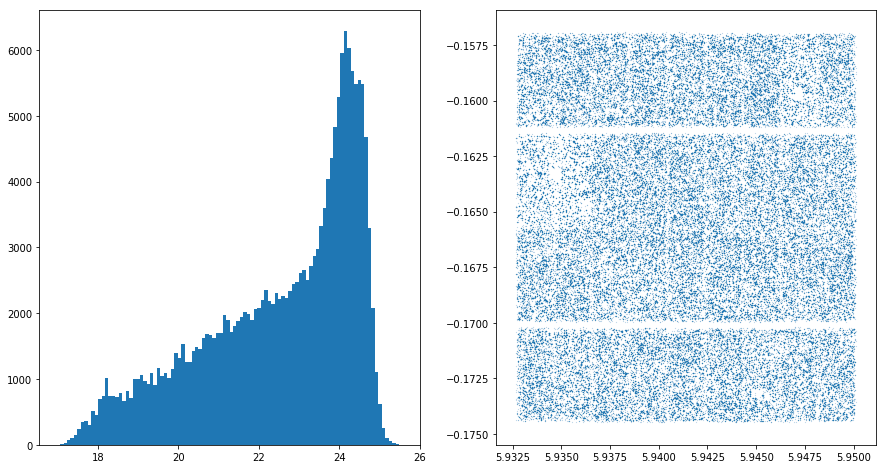

In [23]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(bigCat['mag'], bins=100)
_ = ax1.scatter(bigCat['coord_ra'], bigCat['coord_dec'], s=0.01)

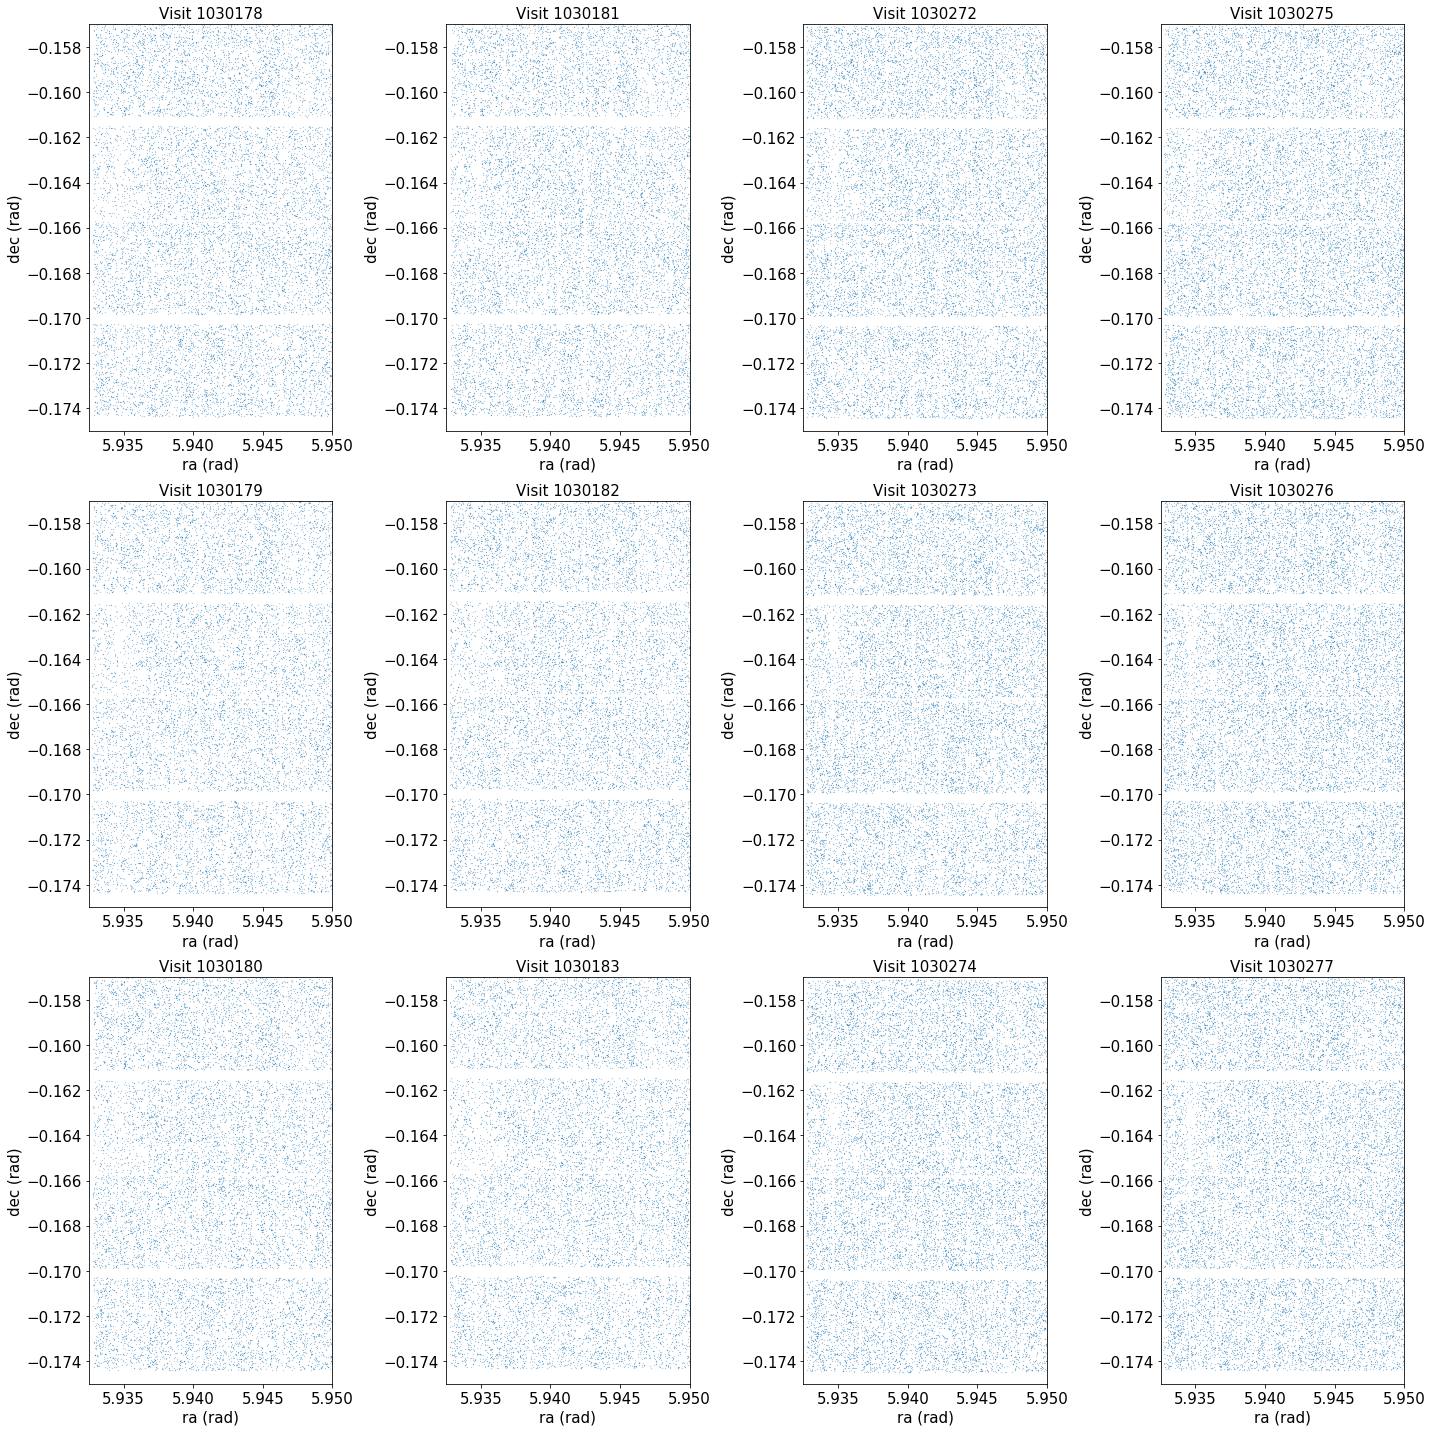

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,20))
for i,v in enumerate(visits):
    a = i%3
    b = i//3
    cut = bigCat['visit'] == v
    ax[a][b].scatter(bigCat[cut]['coord_ra'], bigCat[cut]['coord_dec'], s=0.02)
    ax[a][b].set_xlim([5.9325, 5.9500])
    ax[a][b].set_ylim([-0.175, -0.1570])
    ax[a][b].set_xlabel('ra (rad)', fontsize=15)
    ax[a][b].set_ylabel('dec (rad)', fontsize=15)
    ax[a][b].set_title('Visit %d'%(v), fontsize=15)
    ax[a][b].tick_params(labelsize=15)
    
fig.tight_layout()

In [42]:
#fig.savefig("ra_dec_r.png")

In [24]:
from astropy.coordinates import SkyCoord
from astropy import units as u

visits = [1030178, 1030179, 1030180, 1030181, 1030182, 1030183, 1030272, 1030273, 1030274, 1030275, 1030276, 1030277]
vRef = 1030178
tract = 8006
cRef = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['coord_ra'], dec = bigCat[bigCat['visit']==vRef]['coord_dec'])
cRefNew = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['newRa'], dec = bigCat[bigCat['visit']==vRef]['newDec'])

bigCat['dist'] = 999999.

dist = []
distNew = []
dMag = []
dMagNew = []
for count,v in enumerate(visits):
    if v == vRef:
        dist = dist + [9999.]*sum(bigCat['visit']==vRef)
        distNew = distNew + [9999.]*sum(bigCat['visit']==vRef)
        dMag = dMag + [9999.]*sum(bigCat['visit']==vRef)
        dMagNew = dMagNew + [9999.]*sum(bigCat['visit']==vRef)
        continue
    
    c = SkyCoord(ra = bigCat[bigCat['visit']==v]['coord_ra'], dec = bigCat[bigCat['visit']==v]['coord_dec'])
    cNew = SkyCoord(ra = bigCat[bigCat['visit']==v]['newRa'], dec = bigCat[bigCat['visit']==v]['newDec'])
    idx, d2d, d3d = c.match_to_catalog_sky(cRef)
    idxNew, d2dNew, d3dNew = cNew.match_to_catalog_sky(cRefNew)
    
    dist = dist + d2d.milliarcsecond.tolist()
    distNew = distNew + d2dNew.milliarcsecond.tolist()
    
    dMag = dMag + (bigCat[bigCat['visit']==v]['mag'] - bigCat[bigCat['visit']==vRef]['mag'][idx]).tolist()
    dMagNew = dMagNew + (bigCat[bigCat['visit']==v]['newMag'] - bigCat[bigCat['visit']==vRef]['newMag'][idxNew]).tolist()
    
bigCat['dist'] = dist
bigCat['distNew'] = distNew
bigCat['dMag'] = dMag
bigCat['dMagNew'] = dMagNew

In [ ]:
 bigCat[bigCat['visit']==v]['mag']  - bigCat[bigCat['visit']==vRef]['mag'][idx]

In [ ]:
dMag

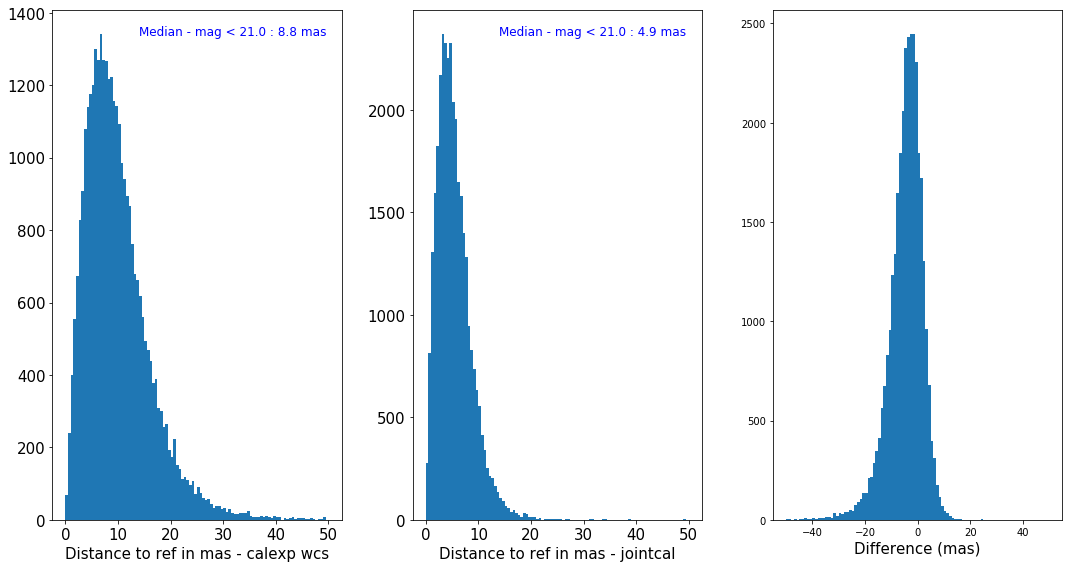

In [25]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))

magCut = 21
cut = (bigCat['dist'] < 300) & (bigCat['distNew'] < 300) & (bigCat['mag'] < magCut)
_ = ax0.hist(bigCat[cut]['dist'], bins=100, range = [0., 50])
_ = ax1.hist(bigCat[cut]['distNew'], bins=100, range = [0., 50])
_ = ax2.hist(bigCat[cut]['distNew'] - bigCat[cut]['dist'], bins=100, range=[-50, 50])

ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax0.set_xlabel('Distance to ref in mas - calexp wcs', fontsize=15)
ax1.set_xlabel('Distance to ref in mas - jointcal', fontsize=15)
ax2.set_xlabel('Difference (mas)', fontsize=15)

ax0.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['dist'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
ax1.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['distNew'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
                                                         
fig.tight_layout()

In [8]:
fig.savefig("DC2_astrometry.png")

0.1118006974998309 0.9075176983870392
20.293697361980442 19.660498558709484


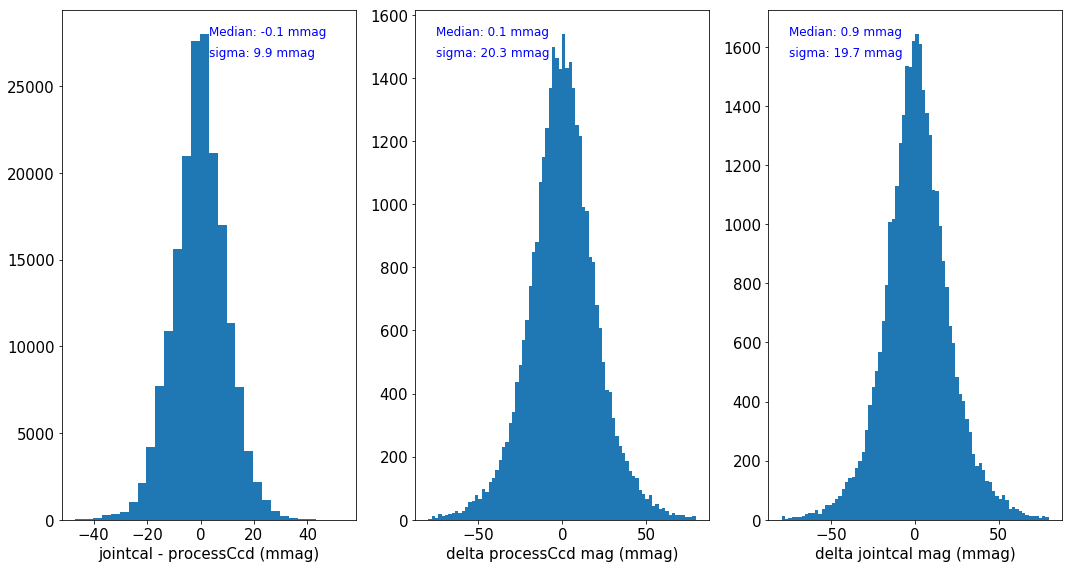

In [26]:
magCut = 21
cut = (bigCat['dMag'] < 0.08) & (bigCat['dMagNew'] < 0.08) & (bigCat['mag'] < magCut) & (bigCat['dMag'] > -0.08) & (bigCat['dMagNew'] > -0.08)
cut &= (bigCat['distNew'] < 50)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))
_ = ax0.hist((bigCat['newMag'] - bigCat['mag'])*1000, bins=30)
_ = ax1.hist(bigCat[cut]['dMag']*1000, bins=80)
_ = ax2.hist(bigCat[cut]['dMagNew']*1000, bins=80)

ax0.set_xlabel('jointcal - processCcd (mmag)', fontsize=15)
ax1.set_xlabel('delta processCcd mag (mmag)', fontsize=15)
ax2.set_xlabel('delta jointcal mag (mmag)', fontsize=15)

ax0.annotate("Median: %0.1f mmag"%(np.median(bigCat['newMag'] - bigCat['mag'])*1000),
             fontsize=12, color='b', xy=(0.5, 0.95), xycoords='axes fraction')
ax0.annotate("sigma: %0.1f mmag"%(np.std(bigCat['newMag'] - bigCat['mag'])*1000),
             fontsize=12, color='b', xy=(0.5, 0.91), xycoords='axes fraction')
ax1.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax1.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')
ax2.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax2.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')


ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

fig.tight_layout()

print(np.median(bigCat[cut]['dMag']*1000), np.median(bigCat[cut]['dMagNew']*1000))
print(np.std(bigCat[cut]['dMag']*1000), np.std(bigCat[cut]['dMagNew']*1000))

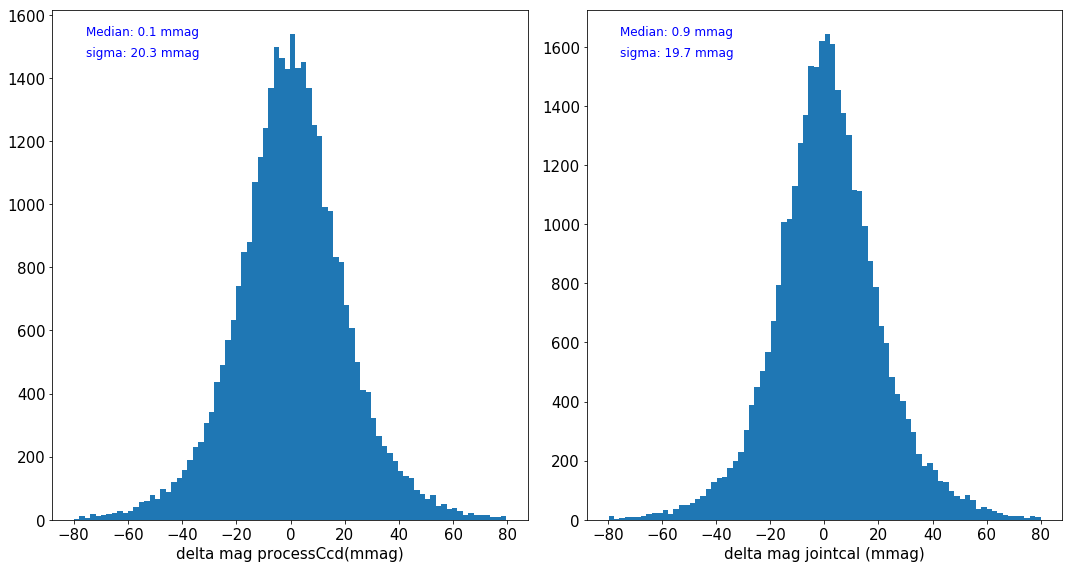

In [14]:
magCut = 21
cut = (bigCat['dMag'] < 0.08) & (bigCat['dMagNew'] < 0.08) & (bigCat['mag'] < magCut) & (bigCat['dMag'] > -0.08) & (bigCat['dMagNew'] > -0.08)
cut &= (bigCat['distNew'] < 50)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax1.hist(bigCat[cut]['dMag']*1000, bins=80)
_ = ax2.hist(bigCat[cut]['dMagNew']*1000, bins=80)

ax1.set_xlabel('delta mag processCcd(mmag)', fontsize=15)
ax2.set_xlabel('delta mag jointcal (mmag)', fontsize=15)

ax1.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax1.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')
ax2.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax2.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')


ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

fig.tight_layout()

In [25]:
fig.savefig("DC2_photometry_constrained.png")

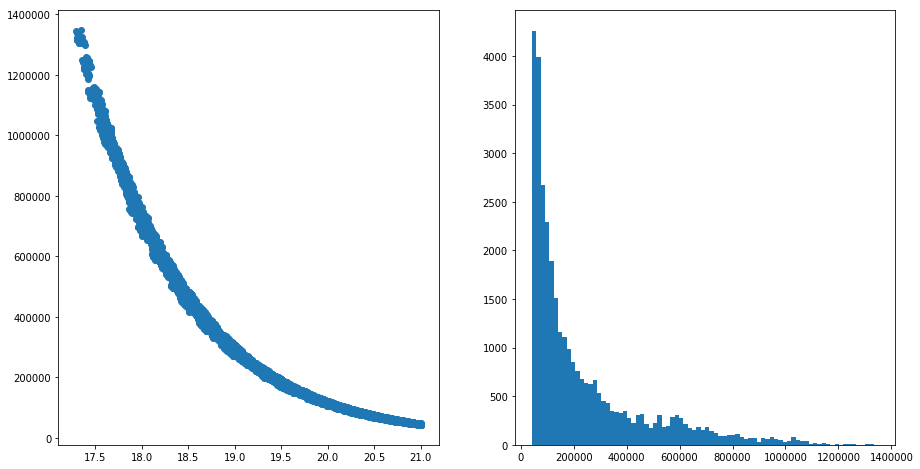

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax1.scatter(bigCat[cut]['mag'], bigCat[cut]['slot_ModelFlux_instFlux'])
_ = ax2.hist(bigCat[cut]['slot_ModelFlux_instFlux'], bins=80)

In [12]:
def getValidDataIds(butler, tract, dataset_type='jointcal_photoCalib'):
    """Return a list of all dataIds that exist in this butler.

    This exists here because the butler doesn't provide this functionality.

    Parameters
    ----------
    butler : `lsst.daf.persistence.Butler`
        The butler to search within.
    tract : `int`
        Tract id to include in search.
    dataset_type : `str`
        Dataset type to search for.
    """
    data_ids = []
    for data_ref in butler.subset(dataset_type, tract=tract):
        if data_ref.datasetExists():
            data_ids.append(data_ref.dataId)
    return data_ids

In [13]:
dataIds = getValidDataIds(butler, 5063)

In [14]:
dataIds

[{'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R12',
  'detectorName': 'S22'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S02'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S11'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S12'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S20'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S21'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R13',
  'detectorName': 'S22'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R14',
  'detectorName': 'S00'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R14',
  'detectorName': 'S01'},
 {'tract': 5063,
  'filter': 'r',
  'visit': 230,
  'raftName': 'R14',
  'detectorName': 'S02'},
 {'tract': 5063,
  'filter': '